In [1]:
import tensorflow as tf
import numpy as np
import util
import os
import matplotlib.pyplot as plt
import cv2

import tensorflow_probability as tfp
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Activation, LeakyReLU, BatchNormalization, Flatten, Reshape
from keras.optimizers import Adam, RMSprop

from IPython import display
import imageio
import glob

tfd = tfp.distributions
tfpl = tfp.layers

### Conv2DTranspose
The formula to calculate the output size of a `Conv2DTranspose` layer depends on the type of padding used.

If you are using ‘SAME’ padding, the formula to calculate the output size is:

```
output_size = input_size * stride
```

where input_size is the size of the input tensor and stride is the stride of the convolution.

If you are using ‘VALID’ padding, the formula to calculate the output size is:

```
output_size = (input_size - 1) * stride + kernel_size
```

where input_size is the size of the input tensor, stride is the stride of the convolution, and kernel_size is the size of the kernel.

If you are using a custom amount of padding, the formula to calculate the output size is:

```
output_size = (input_size - 1) * stride + kernel_size - 2 * padding + output_padding
```

where input_size is the size of the input tensor, stride is the stride of the convolution, kernel_size is the size of the kernel, padding is the amount of zero-padding added to the input tensor, and output_padding is an additional amount of zero-padding added to the output tensor.

### Conv2D
The formula to calculate the output size of a `Conv2D` layer also depends on the type of padding used.

If you are using ‘SAME’ padding, the formula to calculate the output size is:

```
output_size = ceil(input_size / stride)
```
where input_size is the size of the input tensor, stride is the stride of the convolution, and ceil is the ceiling function that rounds up to the nearest integer.

If you are using ‘VALID’ padding, the formula to calculate the output size is:
```
output_size = ceil((input_size - kernel_size + 1) / stride)
```
where input_size is the size of the input tensor, kernel_size is the size of the kernel, stride is the stride of the convolution, and ceil is the ceiling function that rounds up to the nearest integer.

If you are using a custom amount of padding, the formula to calculate the output size is:
```
output_size = ceil((input_size + 2 * padding - kernel_size + 1) / stride)
```
where input_size is the size of the input tensor, padding is the amount of zero-padding added to the input tensor, kernel_size is the size of the kernel, stride is the stride of the convolution, and ceil is the ceiling function that rounds up to the nearest integer.

In [17]:
LEARNING_RATE = 0.0002
BETA1 = 0.5
BATCH_SIZE = 64
EPOCHS = 100
SAVE_SAMPLE_PERIOD = 2
SAMPLE_DIR_NAME = os.path.join('..', 'large_files', 'img_align_celeba')
TRAIN_IMAGES_DIR = 'celeb_train_generated'
act = LeakyReLU(alpha = 0.2)
z = 100 #latent vector dimensionality
#projection = 128
num_examples_to_generate = 16


# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, z])

In [3]:
def load_image(x) :
    #x = Full file path
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [4]:
image_files = tf.data.Dataset.list_files(os.path.join(SAMPLE_DIR_NAME, '*.jpg'), shuffle=False)
image_files = image_files.map(load_image)
image_files = image_files.map(lambda x : tf.image.resize(x, (64, 64)))
image_files = image_files.map(lambda x : (x / 255.0) * 2 - 1)
image_files = image_files.batch(BATCH_SIZE)
image_files

<BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, None), dtype=tf.float32, name=None)>

In [5]:
im = image_files.as_numpy_iterator().next()
im.shape

(64, 64, 64, 3)

In [6]:
D = im.shape[1:]
colors = im.shape[-1]

In [7]:
if not os.path.exists(TRAIN_IMAGES_DIR) :
    os.mkdir(TRAIN_IMAGES_DIR)

In [9]:
i = Input(shape=(D))
x = Conv2D(64, 5, 2, activation = None, padding = 'SAME') (i)
x = BatchNormalization() (x)
x = Activation(act) (x)
x = Conv2D(128, 5, 2, activation = None, padding = 'SAME') (x)
x = BatchNormalization() (x)
x = Activation(act) (x)
x = Conv2D(256, 5, 2, activation = None, padding = 'SAME') (x)
x = BatchNormalization() (x)
x = Activation(act) (x)
x = Flatten() (x)
#x = Dense(1024, activation = None) (x)
#x = BatchNormalization() (x)
#x = Activation(act) (x)
x = Dense(1, activation= None, use_bias = False) (x)

discriminator = Model(i, x)
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        4864      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       204928    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                             

In [10]:
i = Input(shape=(z, ))
x = Dense(8 * 8 * 512, activation = None) (i)
x = BatchNormalization() (x)
x = Activation(act) (x)
x = Reshape((8, 8, 512)) (x)
x = Conv2DTranspose(filters = 128, kernel_size = 5, strides = 1, activation = None, padding = 'same', use_bias=False) (x)
x = BatchNormalization() (x)
x = Activation(act) (x)
x = Conv2DTranspose(filters = 64, kernel_size = 5, strides = 2, activation = None, padding = 'same', use_bias=False) (x)
x = BatchNormalization() (x)
x = Activation(act) (x)
x = Conv2DTranspose(filters = 32, kernel_size = 5, strides = 2, activation = None, padding = 'same', use_bias=False) (x)
x = BatchNormalization() (x)
x = Activation(act) (x)
x = Conv2DTranspose(filters = colors, kernel_size = 5, strides = 2, activation = 'tanh', padding = 'same', use_bias=False) (x)

generator = Model(i, x)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 32768)             3309568   
                                                                 
 batch_normalization_3 (Batc  (None, 32768)            131072    
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        1638400   
 nspose)                                                   

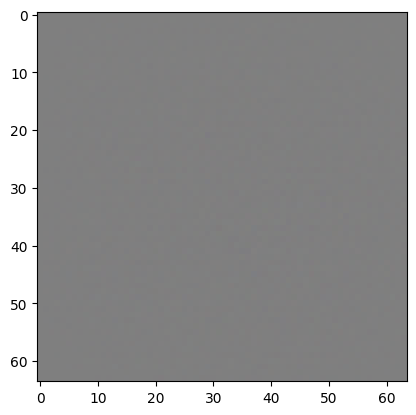

In [11]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image = (((generated_image + 1) / 2) * 255).numpy().astype(np.int32)
plt.imshow(generated_image[0, :, :, :])

In [12]:
generated_image.shape

(1, 64, 64, 3)

In [13]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[10.181052]], shape=(1, 1), dtype=float32)


In [14]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        # Set the epoch number in the model
        self.model.current_epoch = epoch

class DCGAN(Model) :
    def __init__(self, discriminator, generator, **kwargs):
        super().__init__(**kwargs)
        self.discriminator = discriminator
        self.generator = generator
        # Create a non-trainable variable to store the current epoch number
        self.current_epoch = tf.Variable(0, trainable=False)
        
    def compile(self, loss_d, loss_g, opt_d, opt_g, **kwargs):
        super().compile(**kwargs)
        self.loss_d = loss_d
        self.loss_g = loss_g
        self.opt_d = opt_d
        self.opt_g = opt_g
        
    def reparameterize(self, mean, var):
        eps = tf.random.normal(shape=mean.shape)
        return eps * var + mean
    
    def train_step(self, batch, **kwargs):
        ##it takes one batch of data and trains on that batch
        epoch = self.current_epoch
        noise = tf.random.normal([BATCH_SIZE, z])
        X = batch
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training = True)
            
            real_output = self.discriminator(X, training=True)
            fake_output = self.discriminator(generated_images, training=True)
            
            gen_loss = self.loss_g(fake_output)
            disc_loss = self.loss_d(real_output, fake_output)

            
            grad_gen = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            grad_disc = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.opt_g.apply_gradients(zip(grad_gen, self.generator.trainable_variables))
        self.opt_d.apply_gradients(zip(grad_disc, self.discriminator.trainable_variables))
        
        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(self.generator,
                                 epoch + 1,
                                 seed)
        
        return {'gen_loss': gen_loss, 'disc_loss' : disc_loss}
    
    def test_step(self, batch, **kwargs) :
        pass
        
    def call(self, X, **kwargs) :
        pass

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    predictions = (((predictions + 1) / 2) * 255).numpy().astype(np.int32)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :])
        plt.axis('off')

    if epoch % SAVE_SAMPLE_PERIOD == 0 :
        plt.savefig(os.path.join(TRAIN_IMAGES_DIR, f'image_at_epoch_{epoch}.png'))
    plt.show()

In [15]:
dcgan = DCGAN(discriminator = discriminator, generator = generator)

In [16]:
dcgan.compile(
    loss_d = discriminator_loss, 
    loss_g = generator_loss, 
    opt_d = Adam(learning_rate=1e-4), 
    opt_g = Adam(learning_rate=1e-4),
    run_eagerly=True
)

KeyboardInterrupt: 

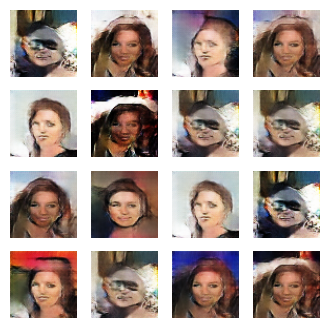

In [18]:
r = dcgan.fit(image_files, epochs=EPOCHS, callbacks=[CustomCallback()])

In [20]:
WEIGHTS_PATH = os.path.join('celeb_weights')
generator.save_weights(os.path.join(WEIGHTS_PATH, 'generator'), save_format='tf')
discriminator.save_weights(os.path.join(WEIGHTS_PATH, 'discriminator'), save_format='tf')
dcgan.save_weights(os.path.join(WEIGHTS_PATH, 'dcgan'), save_format='tf')

In [25]:
anim_file = 'celeb_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(os.path.join(TRAIN_IMAGES_DIR, 'image*.png'))
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

C:\Users\Dhruv\AppData\Local\Temp\ipykernel_16596\951637464.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
C:\Users\Dhruv\AppData\Local\Temp\ipykernel_16596\951637464.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



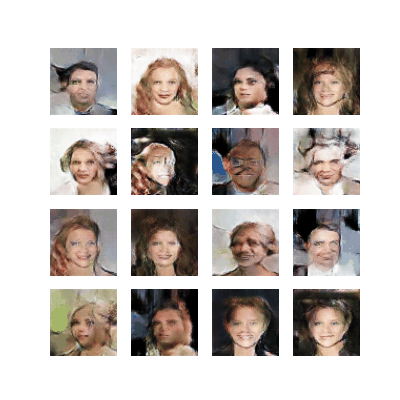

In [26]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)